# Machine Learning Processing

### Contents

 - I. [Data Importing & Processing](#Data-Import-and-Processing)
 - II. [Modeling Plan](#Modeling-Plan)
     - [Iteration 0 - Unprocessed](#Iteration-0:-Non-Scaled-Data-for-Tree-based-Boosting-Models)
     - [Iteration 1 - Scaled](#Iteration-1:-Scaling-the-Pipe)
     - [Iteration 2 - PCA](#Iteration-2:-Give-the-Computer-a-Chance)
     - [Iteration 3 - PCA Boosted](#Iteration-3:-PCABoosted-Modeling)
     - [Best Models](#Best-Models)
 - III. [Preliminary Analysis](#Preliminary-Results-&-Analysis)
     - [Permutation Importance Insights](#Permutation-Importance)
 - IV. [Stacking](#Running-the-Best-Models-for-Full-Training-Data)
     - [Confidence Visualization](#Stacking-Visualization)
 - V. [Conclusions & Discussion](#Conclusions-&-Discussion)

## Data Import and Processing

In [1]:
# Import packages etc.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
from sklearn.model_selection import train_test_split

In [2]:
Xdata = pickle.load(open('Xtrain.pickle', 'rb'))
ydata = pickle.load(open('ytrain.pickle', 'rb'))

# Split the data into train & test sets for supervised learning
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata,
                                               test_size=0.2,
                                               random_state=430)

# Quick Heads Up
print('Training Data shape: ' + str(Xtrain.shape))
print('Test Data Shape: ' + str(Xtest.shape))

Training Data shape: (4328, 71)
Test Data Shape: (1082, 71)


In [3]:
print(np.sum(ydata))
print('Total for len(ydata)')

PotentialFraud    506
dtype: int64
Total for len(ydata)


In [4]:
np.sum(ytrain)

PotentialFraud    395
dtype: int64

# Getting rid of imbalance
## SMOTE


## Modeling Plan
The general strategy of our approach incorporates an initial, broad spectrum testing of models, including the following.
 - Logistic Regression
 - KNN
 - Discriminant Analysis
 - Naive Bayes
 - SVM
 - CatBoost
 - Light GBM

This grouping should represent a decent collection of well-worn, classical methods with exceptionally long history & documentation as well as newer, useful methodologies. Of particular interest to this last point will be **Catboost & Light GBM**, two Gradient Boosting models that have shown a great deal of promise in terms of efficiency & accuracy.

### Iterative Strategy | What We Care About 
 - Iteration 0: Non-Scaled models - Naive modeling with tree-based boosting models
 - Iteration 1: Scaled models
 - Iteration 2: PCA transformed models
 - Iteration 3: PCA Boosting models (PCA features reattached to original data)

In [5]:
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

### Iteration 0: Non-Scaled Data for Tree-based Boosting Models
[Back to Top](#Machine-Learning-Processing)

Both Catboost & Light GBM are capable of handling unscaled and even non-numeric data, and encourage testing their models with datasets that are not extensively transformed. As such, for these 2 models, we have run a separate iteration with non-scaled data. For further reference, please consult their respective documentation. Here we will process these for some initial yield results.

In [6]:
# IT0: CatBoost Classifier
# cb_0 = CatBoostClassifier(verbose = False)
cb_0 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                      ('catboost', CatBoostClassifier(random_state=430, verbose=False))])
cb_0.fit(Xtrain, ytrain)
cb_0_train, cb_0_test = cb_0.score(Xtrain, ytrain), cb_0.score(Xtest, ytest)

cb_grid = {'catboost__depth': [4, 6, 8],
           'catboost__min_data_in_leaf': [1, 2, 4]}
cb_0_opt = GridSearchCV(cb_0, cb_grid, n_jobs=-2, cv=3)
cb_0_opt.fit(Xtrain, ytrain)
cb_0_opt_train, cb_0_opt_test, cb_0_opt_params = cb_0_opt.score(Xtrain, ytrain), cb_0_opt.score(Xtest, ytest), cb_0_opt.best_params_

print('Best Params:', cb_0_opt.best_params_)

Best Params: {'catboost__depth': 6, 'catboost__min_data_in_leaf': 1}


In [7]:
# IT0: Light Gradient Boosting Machine Classifier
# lgbm_0 = LGBMClassifier()
lgbm_0 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('lightgbm', LGBMClassifier(random_state=430))])
lgbm_0.fit(Xtrain, ytrain.values.ravel())
lgbm_0_train, lgbm_0_test = lgbm_0.score(Xtrain, ytrain.values.ravel()), lgbm_0.score(Xtest, ytest.values.ravel())

lgbm_grid = {'lightgbm__num_leaves': [40, 42, 44, 46],
             'lightgbm__max_depth': [9, 11, 13, 15],
             'lightgbm__min_data_in_leaf': [17, 19, 21, 23]}
lgbm_0_opt = GridSearchCV(lgbm_0, lgbm_grid, n_jobs   = -2, cv=3)
lgbm_0_opt.fit(Xtrain, ytrain.values.ravel())
lgbm_0_opt_train, lgbm_0_opt_test, lgbm_0_opt_params = lgbm_0_opt.score(Xtrain, ytrain.values.ravel()), lgbm_0_opt.score(Xtest, ytest.values.ravel()), lgbm_0_opt.best_params_

print('Best Params:', lgbm_0_opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
Best Params: {'lightgbm__max_depth': 11, 'lightgbm__min_data_in_leaf': 21, 'lightgbm__num_leaves': 44}


Creating an iterative list of all new models' train and tests scores generated through hypertransformation tuning

In [8]:
modellist = [ele for ele in ['cb', 'lgbm', 'lgr', 'knn', 'lda', 'gnb', 'svc'] for i in range(16)]
iterlist = [ele for ele in ['_0', '_1', '_2', '_3'] for i in range(2)] * 14
optlist = [ele for ele in ['', '_opt'] for i in range(8)] * 7
traintestlist = ['_train', '_test'] * 56
for idx in range(len(modellist)):
    modellist[idx] = modellist[idx] + iterlist[idx] + optlist[idx] + traintestlist[idx]


Creating a function to tabulate all train and test scores generated by the hypertransformation tuning

In [9]:
def scoring_table(score_list):
    columns = [[ele for ele in ['Iteration0', 'Iteration1', 'Iteration2', 'Iteration3'] for i in range(2)],
               [ele for ele in ['NonScaled', 'Scaled', 'PCA', 'PCABoost'] for i in range(2)],
               ['Train', 'Test'] * 4]
    c_tuples = list(zip(*columns))
    multi_columns = pd.MultiIndex.from_tuples(c_tuples)

    index = [[ele for ele in ['CatBoost', 'LightGBM', 'Logistic', 'KNN', 'LDA', 'GNB', 'SVC'] for i in range(2)], 
             ['default', 'optimized'] * 7]
    i_tuples = list(zip(*index))
    multi_index = pd.MultiIndex.from_tuples(i_tuples)

    scores_df = pd.DataFrame(np.array(score_list).reshape((len(multi_index), len(multi_columns))), 
                 index=multi_index,
                 columns=multi_columns)
    return scores_df

Initializing a new list of scores calculated after Iteration 0 is complete

In [10]:
scores = []
for idx in range(len(modellist)):
    try:
        scores.append(locals()[modellist[idx]])
    except:
        scores.append(np.nan)
scoring_table(scores)

Iteration0           Iteration1      Iteration2       \
                    NonScaled               Scaled             PCA        
                        Train      Test      Train Test      Train Test   
CatBoost default          1.0  0.922366        NaN  NaN        NaN  NaN   
         optimized        1.0  0.922366        NaN  NaN        NaN  NaN   
LightGBM default          1.0  0.920518        NaN  NaN        NaN  NaN   
         optimized        1.0  0.922366        NaN  NaN        NaN  NaN   
Logistic default          NaN       NaN        NaN  NaN        NaN  NaN   
         optimized        NaN       NaN        NaN  NaN        NaN  NaN   
KNN      default          NaN       NaN        NaN  NaN        NaN  NaN   
         optimized        NaN       NaN        NaN  NaN        NaN  NaN   
LDA      default          NaN       NaN        NaN  NaN        NaN  NaN   
         optimized        NaN       NaN        NaN  NaN        NaN  NaN   
GNB      default          NaN       NaN        NaN  NaN        NaN  NaN   
         optimized        NaN       NaN        NaN  NaN        NaN  NaN   
SVC      default          NaN       NaN        NaN  NaN        NaN  NaN   
         optimized        NaN       NaN        NaN  NaN        NaN  NaN   

                   Iteration3       
                     PCABoost       
                        Train Test  
CatBoost default          NaN  NaN  
         optimized        NaN  NaN  
LightGBM default          NaN  NaN  
         optimized        NaN  NaN  
Logistic default          NaN  NaN  
         optimized        NaN  NaN  
KNN      default          NaN  NaN  
         optimized        NaN  NaN  
LDA      default          NaN  NaN  
         optimized        NaN  NaN  
GNB      default          NaN  NaN  
         optimized        NaN  NaN  
SVC      default          NaN  NaN  
         optimized        NaN  NaN

### Iteration 1: Scaling the Pipe
[Back to Top](#Machine-Learning-Processing)

Our goal here will be to test the results with some initial scaling built into a pipeline. 

In [11]:
# IT1: CatBoost Classifier
cb_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                       ('scaler', StandardScaler()),
                       ('catboost', CatBoostClassifier(random_state=430, verbose = False))])
cb_1.fit(Xtrain, ytrain)
cb_1_train, cb_1_test = cb_1.score(Xtrain, ytrain), cb_1.score(Xtest, ytest)

cb_grid = {'catboost__depth': [2, 4, 6, 8],
           'catboost__min_data_in_leaf': [1, 2, 4]}
cb_1_opt = GridSearchCV(cb_1, cb_grid, n_jobs=-2, cv=3)
cb_1_opt.fit(Xtrain, ytrain)
cb_1_opt_train, cb_1_opt_test, cb_1_opt_params = cb_1_opt.score(Xtrain, ytrain), cb_1_opt.score(Xtest, ytest), cb_1_opt.best_params_

print('Best Params:', cb_1_opt.best_params_)

Best Params: {'catboost__depth': 6, 'catboost__min_data_in_leaf': 1}


In [12]:
# IT1: Light Gradient Boosting Machine Classifier
lgbm_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                         ('scaler', StandardScaler()),
                         ('lightgbm', LGBMClassifier(n_jobs=-2, random_state=430))])
lgbm_1.fit(Xtrain, ytrain.values.ravel())
lgbm_1_train, lgbm_1_test = lgbm_1.score(Xtrain, ytrain.values.ravel()), lgbm_1.score(Xtest, ytest.values.ravel())

lgbm_grid = {'lightgbm__num_leaves': [44, 46, 48],
             'lightgbm__max_depth': [9, 11, 13],
             'lightgbm__min_data_in_leaf': [17, 19, 21, 23]}
lgbm_1_opt = GridSearchCV(lgbm_1, lgbm_grid, n_jobs=-2, cv=3)
lgbm_1_opt.fit(Xtrain, ytrain.values.ravel())
lgbm_1_opt_train, lgbm_1_opt_test, lgbm_1_opt_params = lgbm_1_opt.score(Xtrain, ytrain.values.ravel()), lgbm_1_opt.score(Xtest, ytest.values.ravel()), lgbm_1_opt.best_params_

print('Best Params:', lgbm_1_opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
Best Params: {'lightgbm__max_depth': 11, 'lightgbm__min_data_in_leaf': 19, 'lightgbm__num_leaves': 46}


In [13]:
# IT1: Logistic Regression
lgr_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('logistic', LogisticRegression(n_jobs=-2))])
lgr_1.fit(Xtrain, ytrain.values.ravel())
lgr_1_train, lgr_1_test = lgr_1.score(Xtrain, ytrain.values.ravel()), lgr_1.score(Xtest, ytest.values.ravel())

lgr_grid = {'logistic__C': np.linspace(-4, 4, 50),
            'logistic__penalty': ['l1', 'l2']}
lgr_1_opt = GridSearchCV(lgr_1, lgr_grid, n_jobs=-2, cv=3)
lgr_1_opt.fit(Xtrain, ytrain.values.ravel())
lgr_1_opt_train, lgr_1_opt_test, lgr_1_opt_params = lgr_1_opt.score(Xtrain, ytrain.values.ravel()), lgr_1_opt.score(Xtest, ytest.values.ravel()), lgr_1_opt.best_params_

print('Best Params:', lgr_1_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.87777413        nan 0.88077681
        nan 0.88008365        nan 0.88077665        nan 0.88100765
        nan 0.88123833        nan 0.88193133        nan 0.88170033
        nan 0.88193149        nan 0.88170033        nan 0.88146933
        nan 0.88170033        nan 0.8814691

Best Params: {'logistic__C': 1.387755102040816, 'logistic__penalty': 'l2'}


In [14]:
# IT1: K-Nearest Neighbors
knn_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('knn', KNeighborsClassifier(n_jobs=-2))])
knn_1.fit(Xtrain, ytrain.values.ravel())
knn_1_train, knn_1_test = knn_1.score(Xtrain, ytrain.values.ravel()), knn_1.score(Xtest, ytest.values.ravel())

ksqrt = int(np.round(np.sqrt(Xtrain.shape[0])))       # Get sqrt of observations for k
knn_grid = {'knn__n_neighbors': [ksqrt - 5, ksqrt - 3, ksqrt, ksqrt + 3, ksqrt + 5],
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']}
knn_1_opt = GridSearchCV(knn_1, knn_grid, n_jobs=-2, cv=3)
knn_1_opt.fit(Xtrain, ytrain.values.ravel())
knn_1_opt_train, knn_1_opt_test, knn_1_opt_params = knn_1_opt.score(Xtrain, ytrain.values.ravel()), knn_1_opt.score(Xtest, ytest.values.ravel()), knn_1_opt.best_params_

print('Best Params:', knn_1_opt.best_params_)

Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 61, 'knn__weights': 'distance'}


In [15]:
# IT1: Linear Discriminant Analysis
lda_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('lda', LinearDiscriminantAnalysis())])
lda_1.fit(Xtrain, ytrain.values.ravel())
lda_1_train, lda_1_test = lda_1.score(Xtrain, ytrain.values.ravel()), lda_1.score(Xtest, ytest.values.ravel())

lda_grid = {'lda__solver': ['svd', 'lsqr', 'eigen']}
lda_1_opt = GridSearchCV(lda_1, lda_grid, n_jobs=-2, cv=3)
lda_1_opt.fit(Xtrain, ytrain.values.ravel())
lda_1_opt_train, lda_1_opt_test, lda_1_opt_params = lda_1_opt.score(Xtrain, ytrain.values.ravel()), lda_1_opt.score(Xtest, ytest.values.ravel()), lda_1_opt.best_params_

print('Best Params:', lda_1_opt.best_params_)

Best Params: {'lda__solver': 'svd'}


In [16]:
# IT1: Gaussian Naive Bayes
gnb_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('gnb', GaussianNB())])
gnb_1.fit(Xtrain, ytrain.values.ravel())
gnb_1_train, gnb_1_test = gnb_1.score(Xtrain, ytrain.values.ravel()), gnb_1.score(Xtest, ytest.values.ravel())

gnb_grid = {'gnb__var_smoothing': np.logspace(0, -9, num = 100)}
gnb_1_opt = GridSearchCV(gnb_1, gnb_grid, n_jobs=-2, cv=3)
gnb_1_opt.fit(Xtrain, ytrain.values.ravel())
gnb_1_opt_train, gnb_1_opt_test, gnb_1_opt_params = gnb_1_opt.score(Xtrain, ytrain.values.ravel()), gnb_1_opt.score(Xtest, ytest.values.ravel()), gnb_1_opt.best_params_

print('Best Params:', gnb_1_opt.best_params_)

Best Params: {'gnb__var_smoothing': 0.0002310129700083158}


In [17]:
# IT1: Support Vector Machine Classifier
svc_1 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('svc', SVC())])
svc_1.fit(Xtrain, ytrain.values.ravel())
svc_1_train, svc_1_test = svc_1.score(Xtrain, ytrain.values.ravel()), svc_1.score(Xtest, ytest.values.ravel())

svc_grid = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'svc__gamma': ['scale'],
            'svc__C': [0.1, 1, 10, 100, 500, 1000]}
svc_1_opt = GridSearchCV(svc_1, svc_grid, n_jobs=-2, cv=3)
svc_1_opt.fit(Xtrain, ytrain.values.ravel())
svc_1_opt_train, svc_1_opt_test, svc_1_opt_params = svc_1_opt.score(Xtrain, ytrain.values.ravel()), svc_1_opt.score(Xtest, ytest.values.ravel()), svc_1_opt.best_params_

print('Best Params:', svc_1_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


Initializing a new list of scores calculated after Iteration 1 is complete

In [18]:
scores = []
for idx in range(len(modellist)):
    try:
        scores.append(locals()[modellist[idx]])
    except:
        scores.append(np.nan)
scoring_table(scores)

Iteration0           Iteration1           Iteration2       \
                    NonScaled               Scaled                  PCA        
                        Train      Test      Train      Test      Train Test   
CatBoost default          1.0  0.922366   1.000000  0.926063        NaN  NaN   
         optimized        1.0  0.922366   1.000000  0.926063        NaN  NaN   
LightGBM default          1.0  0.920518   1.000000  0.921442        NaN  NaN   
         optimized        1.0  0.922366   1.000000  0.924214        NaN  NaN   
Logistic default          NaN       NaN   0.886322  0.851201        NaN  NaN   
         optimized        NaN       NaN   0.886784  0.848429        NaN  NaN   
KNN      default          NaN       NaN   0.781654  0.702403        NaN  NaN   
         optimized        NaN       NaN   1.000000  0.691312        NaN  NaN   
LDA      default          NaN       NaN   0.845656  0.818854        NaN  NaN   
         optimized        NaN       NaN   0.845656  0.818854        NaN  NaN   
GNB      default          NaN       NaN   0.713031  0.681146        NaN  NaN   
         optimized        NaN       NaN   0.713031  0.681146        NaN  NaN   
SVC      default          NaN       NaN   0.920518  0.865989        NaN  NaN   
         optimized        NaN       NaN   0.996996  0.902957        NaN  NaN   

                   Iteration3       
                     PCABoost       
                        Train Test  
CatBoost default          NaN  NaN  
         optimized        NaN  NaN  
LightGBM default          NaN  NaN  
         optimized        NaN  NaN  
Logistic default          NaN  NaN  
         optimized        NaN  NaN  
KNN      default          NaN  NaN  
         optimized        NaN  NaN  
LDA      default          NaN  NaN  
         optimized        NaN  NaN  
GNB      default          NaN  NaN  
         optimized        NaN  NaN  
SVC      default          NaN  NaN  
         optimized        NaN  NaN

## Iteration 2: Give the Computer a Chance

[Back to Top](#Machine-Learning-Processing)



In [19]:
# IT2: PCA Only
from sklearn.decomposition import PCA 

In [20]:
# IT2: CatBoost Classifier
cb_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                       ('scaler', StandardScaler()),
                       ('PCA', PCA(n_components=0.95, random_state=430)),
                       ('catboost', CatBoostClassifier(random_state=430, verbose = False))])
cb_2.fit(Xtrain, ytrain)
cb_2_train, cb_2_test = cb_2.score(Xtrain, ytrain), cb_2.score(Xtest, ytest)

cb_grid2 = {'catboost__depth': [4, 6, 8],
           'catboost__min_data_in_leaf': [1, 2, 4]}

cb_2_opt = GridSearchCV(cb_2, cb_grid2, n_jobs=-2, cv=3)
cb_2_opt.fit(Xtrain, ytrain)
cb_2_opt_train, cb_2_opt_test, cb_2_opt_params = cb_2_opt.score(Xtrain, ytrain), cb_2_opt.score(Xtest, ytest), cb_2_opt.best_params_

print('Best Params:', cb_2_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'catboost__depth': 6, 'catboost__min_data_in_leaf': 1}


In [21]:
# IT2: Light Gradient Boosting Machine Classifier
lgbm_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                         ('scaler', StandardScaler()),
                         ('PCA', PCA(n_components=0.95, random_state=430)),
                         ('lightgbm', LGBMClassifier(n_jobs=-2, random_state=430))])
lgbm_2.fit(Xtrain, ytrain.values.ravel())
lgbm_2_train, lgbm_2_test = lgbm_2.score(Xtrain, ytrain.values.ravel()), lgbm_2.score(Xtest, ytest.values.ravel())

lgbm_grid2 = {'lightgbm__num_leaves': [44, 46, 48],
              'lightgbm__max_depth': [5, 7, 9, 11],
              'lightgbm__min_data_in_leaf': [13, 15, 17, 19]}

lgbm_2_opt = GridSearchCV(lgbm_2, lgbm_grid2, n_jobs=-2, cv=3)
lgbm_2_opt.fit(Xtrain, ytrain.values.ravel())
lgbm_2_opt_train, lgbm_2_opt_test, lgbm_2_opt_params = lgbm_2_opt.score(Xtrain, ytrain.values.ravel()), lgbm_2_opt.score(Xtest, ytest.values.ravel()), lgbm_2_opt.best_params_

print('Best Params:', lgbm_2_opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
Best Params: {'lightgbm__max_depth': 9, 'lightgbm__min_data_in_leaf': 17, 'lightgbm__num_leaves': 46}


In [22]:
# IT2: Logistic Regression
lgr_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=0.95, random_state=430)),
                        ('logistic', LogisticRegression(n_jobs=-2))])
lgr_2.fit(Xtrain, ytrain.values.ravel())
lgr_2_train, lgr_2_test = lgr_2.score(Xtrain, ytrain.values.ravel()), lgr_2.score(Xtest, ytest.values.ravel())

lgr_2_opt = GridSearchCV(lgr_2, lgr_grid, n_jobs=-2, cv=3)
lgr_2_opt.fit(Xtrain, ytrain.values.ravel())
lgr_2_opt_train, lgr_2_opt_test, lgr_2_opt_params = lgr_2_opt.score(Xtrain, ytrain.values.ravel()), lgr_2_opt.score(Xtest, ytest.values.ravel()), lgr_2_opt.best_params_

print('Best Params:', lgr_2_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.84935341        nan 0.85143273
        nan 0.85097073        nan 0.85143289        nan 0.85143289
        nan 0.85143289        nan 0.85143289        nan 0.85143289
        nan 0.85143289        nan 0.85143289        nan 0.85143289
        nan 0.85143289        nan 0.8516638

Best Params: {'logistic__C': 2.040816326530612, 'logistic__penalty': 'l2'}


In [23]:
# IT2: K-Nearest Neighbors
knn_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=0.95, random_state=430)),
                        ('knn', KNeighborsClassifier(n_jobs=-2))])
knn_2.fit(Xtrain, ytrain.values.ravel())
knn_2_train, knn_2_test = knn_2.score(Xtrain, ytrain.values.ravel()), knn_2.score(Xtest, ytest.values.ravel())

knn_2_opt = GridSearchCV(knn_2, knn_grid, n_jobs=-2, cv=3)
knn_2_opt.fit(Xtrain, ytrain.values.ravel())
knn_2_opt_train, knn_2_opt_test, knn_2_opt_params = knn_2_opt.score(Xtrain, ytrain.values.ravel()), knn_2_opt.score(Xtest, ytest.values.ravel()), knn_2_opt.best_params_

print('Best Params:', knn_2_opt.best_params_)

Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 66, 'knn__weights': 'uniform'}


In [24]:
# IT2: Linear Discriminant Analysis
lda_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=0.95, random_state=430)),
                        ('lda', LinearDiscriminantAnalysis())])
lda_2.fit(Xtrain, ytrain.values.ravel())
lda_2_train, lda_2_test = lda_2.score(Xtrain, ytrain.values.ravel()), lda_2.score(Xtest, ytest.values.ravel())

lda_2_opt = GridSearchCV(lda_2, lda_grid, n_jobs=-2, cv=3)
lda_2_opt.fit(Xtrain, ytrain.values.ravel())
lda_2_opt_train, lda_2_opt_test, lda_2_opt_params = lda_2_opt.score(Xtrain, ytrain.values.ravel()), lda_2_opt.score(Xtest, ytest.values.ravel()), lda_2_opt.best_params_

print('Best Params:', lda_2_opt.best_params_)

Best Params: {'lda__solver': 'svd'}


In [25]:
# IT2: Gaussian Naive Bayes
gnb_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=0.95, random_state=430)),
                        ('gnb', GaussianNB())])
gnb_2.fit(Xtrain, ytrain.values.ravel())
gnb_2_train, gnb_2_test = gnb_2.score(Xtrain, ytrain.values.ravel()), gnb_2.score(Xtest, ytest.values.ravel())

gnb_2_opt = GridSearchCV(gnb_2, gnb_grid, n_jobs=-2, cv=3)
gnb_2_opt.fit(Xtrain, ytrain.values.ravel())
gnb_2_opt_train, gnb_2_opt_test, gnb_2_opt_params = gnb_2_opt.score(Xtrain, ytrain.values.ravel()), gnb_2_opt.score(Xtest, ytest.values.ravel()), gnb_2_opt.best_params_
print('Best Params:', gnb_2_opt.best_params_)

Best Params: {'gnb__var_smoothing': 1.5199110829529332e-05}


In [26]:
# IT2: Support Vector Machine Classifier
svc_2 = Pipeline(steps=[('smote', SMOTE(n_jobs=-2, random_state=430)),
                        ('scaler', StandardScaler()),
                        ('PCA', PCA(n_components=0.95, random_state=430)),
                        ('svc', SVC())])
svc_2.fit(Xtrain, ytrain.values.ravel())
svc_2_train, svc_2_test = svc_2.score(Xtrain, ytrain.values.ravel()), svc_2.score(Xtest, ytest.values.ravel())

svc_grid2 = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'svc__gamma': ['scale'],
            'svc__C': [0.1, 1, 10, 100, 500, 1000]}

svc_2_opt = GridSearchCV(svc_2, svc_grid2, n_jobs=-2, cv=3)
svc_2_opt.fit(Xtrain, ytrain.values.ravel())
svc_2_opt_train, svc_2_opt_test, svc_2_opt_params = svc_2_opt.score(Xtrain, ytrain.values.ravel()), svc_2_opt.score(Xtest, ytest.values.ravel()), svc_2_opt.best_params_
print('Best Params:', svc_2_opt.best_params_)

Best Params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


Initializing a new list of scores calculated after Iteration 2 is complete

In [27]:
scores = []
for idx in range(len(modellist)):
    try:
        scores.append(locals()[modellist[idx]])
    except:
        scores.append(np.nan)
scoring_table(scores)

Iteration0           Iteration1           Iteration2  \
                    NonScaled               Scaled                  PCA   
                        Train      Test      Train      Test      Train   
CatBoost default          1.0  0.922366   1.000000  0.926063   0.998845   
         optimized        1.0  0.922366   1.000000  0.926063   0.998845   
LightGBM default          1.0  0.920518   1.000000  0.921442   0.999538   
         optimized        1.0  0.922366   1.000000  0.924214   1.000000   
Logistic default          NaN       NaN   0.886322  0.851201   0.857671   
         optimized        NaN       NaN   0.886784  0.848429   0.857671   
KNN      default          NaN       NaN   0.781654  0.702403   0.788355   
         optimized        NaN       NaN   1.000000  0.691312   0.677218   
LDA      default          NaN       NaN   0.845656  0.818854   0.791821   
         optimized        NaN       NaN   0.845656  0.818854   0.791821   
GNB      default          NaN       NaN   0.713031  0.681146   0.611137   
         optimized        NaN       NaN   0.713031  0.681146   0.611137   
SVC      default          NaN       NaN   0.920518  0.865989   0.911738   
         optimized        NaN       NaN   0.996996  0.902957   0.992606   

                             Iteration3       
                               PCABoost       
                        Test      Train Test  
CatBoost default    0.899261        NaN  NaN  
         optimized  0.899261        NaN  NaN  
LightGBM default    0.898336        NaN  NaN  
         optimized  0.897412        NaN  NaN  
Logistic default    0.825323        NaN  NaN  
         optimized  0.825323        NaN  NaN  
KNN      default    0.718115        NaN  NaN  
         optimized  0.658965        NaN  NaN  
LDA      default    0.772643        NaN  NaN  
         optimized  0.772643        NaN  NaN  
GNB      default    0.588725        NaN  NaN  
         optimized  0.588725        NaN  NaN  
SVC      default    0.854898        NaN  NaN  
         optimized  0.887246        NaN  NaN

## Iteration 3: PCABoosted Modeling
[Back to Top](#Machine-Learning-Processing)

Considering that the PCABoost function does not play well with Pipeline, we have pre-processed the data here, first with scaling and then with the PCA Boost. For optimal results, SMOTE needs to be implemented after the PCABoost concatenation.

## Iteration 3: PCABoosted Modeling
[Back to Top](#Machine-Learning-Processing)

Considering that the bespoke function would not play well with Pipeline, we have pre-processed the data here, first with scaling and then with the PCA Boost. 

In [28]:
def PCAmerge(train, test, n_comp=0.95, r_state=430):
    from sklearn.decomposition import PCA 
    pca = PCA(n_components = n_comp, random_state = r_state)
    train_pca = pd.DataFrame(pca.fit_transform(train), index=train.index)
    test_pca = pd.DataFrame(pca.transform(test), index=test.index)
    PCA_col_list = []
    for num in range(1, train_pca.shape[1]+1):
        PCA_col_list.append(('PCA' + str(num)))
    train_pca.columns = PCA_col_list
    train = pd.concat([train, train_pca], axis=1)
    test_pca.columns = PCA_col_list
    test = pd.concat([test, test_pca], axis=1)
    return train, test

In [29]:
# IT3: PCA Boosted Models
scaled = StandardScaler()
smiter = SMOTE(n_jobs=-2, random_state=430)
sm_Xtrain, sm_ytrain = smiter.fit_resample(Xtrain, ytrain)
Xtrain_Scaled = pd.DataFrame(scaled.fit_transform(sm_Xtrain), columns = sm_Xtrain.columns, index = sm_Xtrain.index)
Xtest_Scaled = pd.DataFrame(scaled.fit_transform(Xtest), columns = Xtest.columns, index = Xtest.index)
XtrainPCA, XtestPCA = PCAmerge(Xtrain_Scaled, Xtest_Scaled, n_comp=0.95)

In [30]:
# IT3: CatBoost Classifier
cb_3 = CatBoostClassifier(random_state=430, verbose = False)
cb_3.fit(XtrainPCA, sm_ytrain)
cb_3_train, cb_3_test = cb_3.score(XtrainPCA, sm_ytrain), cb_3.score(XtestPCA, ytest)

cb_grid = {'depth': [8, 10, 12, 14],
          'min_data_in_leaf': [1, 2, 4]}
cb_3_opt = GridSearchCV(cb_3, cb_grid, n_jobs=-2, cv=3)
cb_3_opt.fit(XtrainPCA, sm_ytrain)
cb_3_opt_train, cb_3_opt_test, cb_3_opt_params = cb_3_opt.score(XtrainPCA, sm_ytrain), cb_3_opt.score(XtestPCA, ytest), cb_3_opt.best_params_

print('Best Params:', cb_3_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'depth': 10, 'min_data_in_leaf': 1}


In [31]:
# IT3: Light Gradient Boosting Machine Classifier
lgbm_3 = LGBMClassifier(n_jobs=-2, random_state=430)
lgbm_3.fit(XtrainPCA, sm_ytrain.values.ravel())
lgbm_3_train, lgbm_3_test = lgbm_3.score(XtrainPCA, sm_ytrain.values.ravel()), lgbm_3.score(XtestPCA, ytest.values.ravel())

lgbm_grid = {'num_leaves': [44, 46, 48],
             'max_depth': [9, 11, 13],
             'min_data_in_leaf': [17, 19, 21, 23]}
lgbm_3_opt = GridSearchCV(lgbm_3, lgbm_grid, n_jobs=-2, cv=3)
lgbm_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
lgbm_3_opt_train, lgbm_3_opt_test, lgbm_3_opt_params = lgbm_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), lgbm_3_opt.score(XtestPCA, ytest.values.ravel()), lgbm_3_opt.best_params_

print('Best Params:', lgbm_3_opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
Best Params: {'max_depth': 9, 'min_data_in_leaf': 21, 'num_leaves': 48}


In [32]:
# IT3: Logistic Regression
lgr_3 = LogisticRegression(n_jobs=-2)
lgr_3.fit(XtrainPCA, sm_ytrain.values.ravel())
lgr_3_train, lgr_3_test = lgr_3.score(XtrainPCA, sm_ytrain.values.ravel()), lgr_3.score(XtestPCA, ytest.values.ravel())

lgr_grid = {'C': np.linspace(-4, 4, 50),
            'penalty': ['l1', 'l2']}
lgr_3_opt = GridSearchCV(lgr_3, lgr_grid, n_jobs=-2, cv=3)
lgr_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
lgr_3_opt_train, lgr_3_opt_test, lgr_3_opt_params = lgr_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), lgr_3_opt.score(XtestPCA, ytest.values.ravel()), lgr_3_opt.best_params_

print('Best Params:', lgr_3_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.89168574        nan 0.89448258
        nan 0.89486397        nan 0.8949911         nan 0.89549962
        nan 0.8962624         nan 0.8962624         nan 0.8962624
        nan 0.89524536        nan 0.89575388        nan 0.89562675
        nan 0.89575388        nan 0.89562675

Best Params: {'C': 0.8979591836734686, 'penalty': 'l2'}


In [33]:
# IT3: K-Nearest Neighbors
knn_3 = KNeighborsClassifier(n_jobs=-2)
knn_3.fit(XtrainPCA, sm_ytrain.values.ravel())
knn_3_train, knn_3_test = knn_3.score(XtrainPCA, sm_ytrain.values.ravel()), knn_3.score(XtestPCA, ytest.values.ravel())

knn_grid = {'n_neighbors': [66, 69, 71, 73, 75],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}
knn_3_opt = GridSearchCV(knn_3, knn_grid, n_jobs=-2, cv=3)
knn_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
knn_3_opt_train, knn_3_opt_test, knn_3_opt_params = knn_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), knn_3_opt.score(XtestPCA, ytest.values.ravel()), knn_3_opt.best_params_

print('Best Params:', knn_3_opt.best_params_)

Best Params: {'metric': 'manhattan', 'n_neighbors': 71, 'weights': 'distance'}


In [34]:
# IT3: Linear Discriminant Analysis
lda_3 = LinearDiscriminantAnalysis()
lda_3.fit(XtrainPCA, sm_ytrain.values.ravel())
lda_3_train, lda_3_test = lda_3.score(XtrainPCA, sm_ytrain.values.ravel()), lda_3.score(XtestPCA, ytest.values.ravel())

lda_grid = {'solver': ['svd', 'lsqr', 'eigen']}
lda_3_opt = GridSearchCV(lda_3, lda_grid, n_jobs=-2, cv=3)
lda_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
lda_3_opt_train, lda_3_opt_test, lda_3_opt_params = lda_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), lda_3_opt.score(XtestPCA, ytest.values.ravel()), lda_3_opt.best_params_

print('Best Params:', lda_3_opt.best_params_)

Best Params: {'solver': 'lsqr'}


/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.87935418 0.8798627         nan]
  warnings.warn(


In [35]:
# IT3: Gaussian Naive Bayes
gnb_3 = GaussianNB()
gnb_3.fit(XtrainPCA, sm_ytrain.values.ravel())
gnb_3_train, gnb_3_test = gnb_3.score(XtrainPCA, sm_ytrain.values.ravel()), gnb_3.score(XtestPCA, ytest.values.ravel())

gnb_grid = {'var_smoothing': np.logspace(0, -9, num = 100)}
gnb_3_opt = GridSearchCV(gnb_3, gnb_grid, n_jobs=-2, cv=3)
gnb_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
gnb_3_opt_train, gnb_3_opt_test, gnb_3_opt_params = gnb_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), gnb_3_opt.score(XtestPCA, ytest.values.ravel()), gnb_3_opt.best_params_
print('Best Params:', gnb_3_opt.best_params_)

Best Params: {'var_smoothing': 2.848035868435799e-05}


In [36]:
# IT3: Support Vector Machine Classifier
svc_3 = SVC()
svc_3.fit(XtrainPCA, sm_ytrain.values.ravel())
svc_3_train, svc_3_test = svc_3.score(XtrainPCA, sm_ytrain.values.ravel()), svc_3.score(XtestPCA, ytest.values.ravel())

svc_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale'],
            'C': [0.1, 1, 10, 100, 500, 1000]}
svc_3_opt = GridSearchCV(svc_3, svc_grid, n_jobs=-2, cv=3)
svc_3_opt.fit(XtrainPCA, sm_ytrain.values.ravel())
svc_3_opt_train, svc_3_opt_test, svc_3_opt_params = svc_3_opt.score(XtrainPCA, sm_ytrain.values.ravel()), svc_3_opt.score(XtestPCA, ytest.values.ravel()), svc_3_opt.best_params_
print('Best Params:', svc_3_opt.best_params_)

Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [37]:
def PCAmerge(train, test, n_comp=0.95, r_state=430):
    from sklearn.decomposition import PCA 
    pca = PCA(n_components = n_comp, random_state = r_state)
    train_pca = pd.DataFrame(pca.fit_transform(train), index=train.index)
    test_pca = pd.DataFrame(pca.transform(test), index=test.index)
    PCA_col_list = []
    for num in range(1, train_pca.shape[1]+1):
        PCA_col_list.append(('PCA' + str(num)))
    train_pca.columns = PCA_col_list
    train = pd.concat([train, train_pca], axis=1)
    test_pca.columns = PCA_col_list
    test = pd.concat([test, test_pca], axis=1)
    return train, test

In [38]:
# IT3: PCA Boosted Models
scaled = StandardScaler()
smiter = SMOTE(n_jobs=-1, random_state=430)
Xtrain_Scaled = pd.DataFrame(scaled.fit_transform(Xtrain), columns = Xtrain.columns, index = Xtrain.index)
Xtest_Scaled = pd.DataFrame(scaled.fit_transform(Xtest), columns = Xtest.columns, index = Xtest.index)
XtrainPCA, XtestPCA = PCAmerge(Xtrain_Scaled, Xtest_Scaled, n_comp=0.95)
sm_XtrainPCA, sm_ytrain = smiter.fit_resample(XtrainPCA, ytrain)

In [39]:
# IT3: CatBoost Classifier
cb_3 = CatBoostClassifier(random_state=430, verbose = False)
cb_3.fit(sm_XtrainPCA, sm_ytrain)
cb_3_train, cb_3_test = cb_3.score(sm_XtrainPCA, sm_ytrain), cb_3.score(XtestPCA, ytest)

cb_grid = {'depth': [8, 10, 12, 14],
          'min_data_in_leaf': [1, 2, 4]}
cb_3_opt = GridSearchCV(cb_3, cb_grid, n_jobs=-2, cv=3)
cb_3_opt.fit(sm_XtrainPCA, sm_ytrain)
cb_3_opt_train, cb_3_opt_test, cb_3_opt_params = cb_3_opt.score(sm_XtrainPCA, sm_ytrain), cb_3_opt.score(XtestPCA, ytest), cb_3_opt.best_params_

print('Best Params:', cb_3_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'depth': 10, 'min_data_in_leaf': 1}


In [40]:
# IT3: Light Gradient Boosting Machine Classifier
lgbm_3 = LGBMClassifier(n_jobs=-2, random_state=430)
lgbm_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lgbm_3_train, lgbm_3_test = lgbm_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lgbm_3.score(XtestPCA, ytest.values.ravel())

lgbm_grid = {'num_leaves': [44, 46, 48],
             'max_depth': [9, 11, 13],
             'min_data_in_leaf': [17, 19, 21, 23]}
lgbm_3_opt = GridSearchCV(lgbm_3, lgbm_grid, n_jobs=-2, cv=3)
lgbm_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lgbm_3_opt_train, lgbm_3_opt_test, lgbm_3_opt_params = lgbm_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lgbm_3_opt.score(XtestPCA, ytest.values.ravel()), lgbm_3_opt.best_params_

print('Best Params:', lgbm_3_opt.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
Best Params: {'max_depth': 9, 'min_data_in_leaf': 19, 'num_leaves': 46}


In [41]:
# IT3: Logistic Regression
lgr_3 = LogisticRegression(n_jobs=-2)
lgr_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lgr_3_train, lgr_3_test = lgr_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lgr_3.score(XtestPCA, ytest.values.ravel())

lgr_grid = {'C': np.linspace(-4, 4, 50),
            'penalty': ['l1', 'l2']}
lgr_3_opt = GridSearchCV(lgr_3, lgr_grid, n_jobs=-2, cv=3)
lgr_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lgr_3_opt_train, lgr_3_opt_test, lgr_3_opt_params = lgr_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lgr_3_opt.score(XtestPCA, ytest.values.ravel()), lgr_3_opt.best_params_

print('Best Params:', lgr_3_opt.best_params_)

/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.89855072        nan 0.8993135
        nan 0.89918637        nan 0.89956776        nan 0.90071192
        nan 0.90007628        nan 0.89956776        nan 0.89969489
        nan 0.89944063        nan 0.90020341        nan 0.89956776
        nan 0.89893211        nan 0.89994915

Best Params: {'C': 0.7346938775510203, 'penalty': 'l2'}


In [42]:
# IT3: K-Nearest Neighbors
knn_3 = KNeighborsClassifier(n_jobs=-2)
knn_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
knn_3_train, knn_3_test = knn_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), knn_3.score(XtestPCA, ytest.values.ravel())

knn_grid = {'n_neighbors': [66, 69, 71, 73, 75],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}
knn_3_opt = GridSearchCV(knn_3, knn_grid, n_jobs=-2, cv=3)
knn_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
knn_3_opt_train, knn_3_opt_test, knn_3_opt_params = knn_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), knn_3_opt.score(XtestPCA, ytest.values.ravel()), knn_3_opt.best_params_

print('Best Params:', knn_3_opt.best_params_)

Best Params: {'metric': 'manhattan', 'n_neighbors': 66, 'weights': 'distance'}


In [43]:
# IT3: Linear Discriminant Analysis
lda_3 = LinearDiscriminantAnalysis()
lda_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lda_3_train, lda_3_test = lda_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lda_3.score(XtestPCA, ytest.values.ravel())

lda_grid = {'solver': ['svd', 'lsqr', 'eigen']}
lda_3_opt = GridSearchCV(lda_3, lda_grid, n_jobs=-2, cv=3)
lda_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
lda_3_opt_train, lda_3_opt_test, lda_3_opt_params = lda_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), lda_3_opt.score(XtestPCA, ytest.values.ravel()), lda_3_opt.best_params_

print('Best Params:', lda_3_opt.best_params_)

Best Params: {'solver': 'lsqr'}


/home/theodore/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.87566743 0.87604882        nan]
  warnings.warn(


In [44]:
# IT3: Gaussian Naive Bayes
gnb_3 = GaussianNB()
gnb_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
gnb_3_train, gnb_3_test = gnb_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), gnb_3.score(XtestPCA, ytest.values.ravel())

gnb_grid = {'var_smoothing': np.logspace(0, -9, num = 100)}
gnb_3_opt = GridSearchCV(gnb_3, gnb_grid, n_jobs=-2, cv=3)
gnb_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
gnb_3_opt_train, gnb_3_opt_test, gnb_3_opt_params = gnb_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), gnb_3_opt.score(XtestPCA, ytest.values.ravel()), gnb_3_opt.best_params_
print('Best Params:', gnb_3_opt.best_params_)

Best Params: {'var_smoothing': 5.3366992312063123e-05}


In [45]:
# IT3: Support Vector Machine Classifier
svc_3 = SVC()
svc_3.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
svc_3_train, svc_3_test = svc_3.score(sm_XtrainPCA, sm_ytrain.values.ravel()), svc_3.score(XtestPCA, ytest.values.ravel())

svc_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale'],
            'C': [0.1, 1, 10, 100, 500, 1000]}
svc_3_opt = GridSearchCV(svc_3, svc_grid, n_jobs=-2, cv=3)
svc_3_opt.fit(sm_XtrainPCA, sm_ytrain.values.ravel())
svc_3_opt_train, svc_3_opt_test, svc_3_opt_params = svc_3_opt.score(sm_XtrainPCA, sm_ytrain.values.ravel()), svc_3_opt.score(XtestPCA, ytest.values.ravel()), svc_3_opt.best_params_
print('Best Params:', svc_3_opt.best_params_)

Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Initializing a final list of scores calculated after Iteration 3 is complete

Initializing a final list of scores calculated after Iteration 3 is complete

In [46]:
scores = []
for idx in range(len(modellist)):
    try:
        scores.append(locals()[modellist[idx]])
    except:
        scores.append(np.nan)
scoring_table(scores)

Iteration0           Iteration1           Iteration2  \
                    NonScaled               Scaled                  PCA   
                        Train      Test      Train      Test      Train   
CatBoost default          1.0  0.922366   1.000000  0.926063   0.998845   
         optimized        1.0  0.922366   1.000000  0.926063   0.998845   
LightGBM default          1.0  0.920518   1.000000  0.921442   0.999538   
         optimized        1.0  0.922366   1.000000  0.924214   1.000000   
Logistic default          NaN       NaN   0.886322  0.851201   0.857671   
         optimized        NaN       NaN   0.886784  0.848429   0.857671   
KNN      default          NaN       NaN   0.781654  0.702403   0.788355   
         optimized        NaN       NaN   1.000000  0.691312   0.677218   
LDA      default          NaN       NaN   0.845656  0.818854   0.791821   
         optimized        NaN       NaN   0.845656  0.818854   0.791821   
GNB      default          NaN       NaN   0.713031  0.681146   0.611137   
         optimized        NaN       NaN   0.713031  0.681146   0.611137   
SVC      default          NaN       NaN   0.920518  0.865989   0.911738   
         optimized        NaN       NaN   0.996996  0.902957   0.992606   

                             Iteration3            
                               PCABoost            
                        Test      Train      Test  
CatBoost default    0.899261   1.000000  0.876155  
         optimized  0.899261   1.000000  0.896488  
LightGBM default    0.898336   1.000000  0.869686  
         optimized  0.897412   1.000000  0.867837  
Logistic default    0.825323   0.903636  0.878004  
         optimized  0.825323   0.903127  0.878004  
KNN      default    0.718115   0.901856  0.757856  
         optimized  0.658965   1.000000  0.702403  
LDA      default    0.772643   0.882151  0.797597  
         optimized  0.772643   0.879608  0.365065  
GNB      default    0.588725   0.792652  0.662662  
         optimized  0.588725   0.792016  0.660813  
SVC      default    0.854898   0.939359  0.880776  
         optimized  0.887246   0.998220  0.902957

In [47]:
scores = []
for idx in range(len(modellist)):
    try:
        scores.append(locals()[modellist[idx]])
    except:
        scores.append(np.nan)
scoring_table(scores)

Iteration0           Iteration1           Iteration2  \
                    NonScaled               Scaled                  PCA   
                        Train      Test      Train      Test      Train   
CatBoost default          1.0  0.922366   1.000000  0.926063   0.998845   
         optimized        1.0  0.922366   1.000000  0.926063   0.998845   
LightGBM default          1.0  0.920518   1.000000  0.921442   0.999538   
         optimized        1.0  0.922366   1.000000  0.924214   1.000000   
Logistic default          NaN       NaN   0.886322  0.851201   0.857671   
         optimized        NaN       NaN   0.886784  0.848429   0.857671   
KNN      default          NaN       NaN   0.781654  0.702403   0.788355   
         optimized        NaN       NaN   1.000000  0.691312   0.677218   
LDA      default          NaN       NaN   0.845656  0.818854   0.791821   
         optimized        NaN       NaN   0.845656  0.818854   0.791821   
GNB      default          NaN       NaN   0.713031  0.681146   0.611137   
         optimized        NaN       NaN   0.713031  0.681146   0.611137   
SVC      default          NaN       NaN   0.920518  0.865989   0.911738   
         optimized        NaN       NaN   0.996996  0.902957   0.992606   

                             Iteration3            
                               PCABoost            
                        Test      Train      Test  
CatBoost default    0.899261   1.000000  0.876155  
         optimized  0.899261   1.000000  0.896488  
LightGBM default    0.898336   1.000000  0.869686  
         optimized  0.897412   1.000000  0.867837  
Logistic default    0.825323   0.903636  0.878004  
         optimized  0.825323   0.903127  0.878004  
KNN      default    0.718115   0.901856  0.757856  
         optimized  0.658965   1.000000  0.702403  
LDA      default    0.772643   0.882151  0.797597  
         optimized  0.772643   0.879608  0.365065  
GNB      default    0.588725   0.792652  0.662662  
         optimized  0.588725   0.792016  0.660813  
SVC      default    0.854898   0.939359  0.880776  
         optimized  0.887246   0.998220  0.902957

## Best Models
[Back to Top](#Machine-Learning-Processing)


Creating a table of the best hypertransformations for each ML model, comparing test scores among all iterations.    
These will guide our treatment of the full Xtrain data in the next section.

In [48]:
models = ['CatBoost', 'LightGBM', 'Logistic', 'KNN', 'LDA', 'GNB', 'SVC']
model_scores_balanced = scoring_table(scores)
test_scores = model_scores_balanced.loc[:, model_scores_balanced.columns.get_level_values(2) == 'Test'].unstack(1).T
best_models_balanced = pd.DataFrame([], columns = ['Iteration', 'Transformation', 'Test_Train', 'Optimized', 'Test Score'])
for model in models:
    best_models_balanced.loc[model] = test_scores[model].sort_values(ascending=False).reset_index().iloc[0].values
best_models_balanced = best_models_balanced.drop('Test_Train', axis=1)
best_models_balanced

,Iteration,Transformation,Optimized,Test Score
CatBoost,Iteration1,Scaled,default,0.926063
LightGBM,Iteration1,Scaled,optimized,0.924214
Logistic,Iteration3,PCABoost,default,0.878004
KNN,Iteration3,PCABoost,default,0.757856
LDA,Iteration1,Scaled,default,0.818854
GNB,Iteration1,Scaled,default,0.681146
SVC,Iteration1,Scaled,optimized,0.902957


Getting rid of '_0' entries by generating a reduced list of model names

In [49]:
modellistreduced = modellist.copy()

num_list = [105, 104]
i = 0
while i < 9:
    max_idx = len(num_list) - 1
    num_list.append(num_list[max_idx - 1] - 8)
    num_list.append(num_list[max_idx] - 8)
    i += 1

for num in num_list:
    modellistreduced.pop(num)
modellistreduced

['cb_0_train',
 'cb_0_test',
 'cb_1_train',
 'cb_1_test',
 'cb_2_train',
 'cb_2_test',
 'cb_3_train',
 'cb_3_test',
 'cb_0_opt_train',
 'cb_0_opt_test',
 'cb_1_opt_train',
 'cb_1_opt_test',
 'cb_2_opt_train',
 'cb_2_opt_test',
 'cb_3_opt_train',
 'cb_3_opt_test',
 'lgbm_0_train',
 'lgbm_0_test',
 'lgbm_1_train',
 'lgbm_1_test',
 'lgbm_2_train',
 'lgbm_2_test',
 'lgbm_3_train',
 'lgbm_3_test',
 'lgbm_0_opt_train',
 'lgbm_0_opt_test',
 'lgbm_1_opt_train',
 'lgbm_1_opt_test',
 'lgbm_2_opt_train',
 'lgbm_2_opt_test',
 'lgbm_3_opt_train',
 'lgbm_3_opt_test',
 'lgr_1_train',
 'lgr_1_test',
 'lgr_2_train',
 'lgr_2_test',
 'lgr_3_train',
 'lgr_3_test',
 'lgr_1_opt_train',
 'lgr_1_opt_test',
 'lgr_2_opt_train',
 'lgr_2_opt_test',
 'lgr_3_opt_train',
 'lgr_3_opt_test',
 'knn_1_train',
 'knn_1_test',
 'knn_2_train',
 'knn_2_test',
 'knn_3_train',
 'knn_3_test',
 'knn_1_opt_train',
 'knn_1_opt_test',
 'knn_2_opt_train',
 'knn_2_opt_test',
 'knn_3_opt_train',
 'knn_3_opt_test',
 'lda_1_train',
 'ld

Getting a list of model names

In [50]:
modelinputlist = modellistreduced.copy()
for idx in range(len(modelinputlist)):
    if idx % 2 == 0:
        modelinputlist[idx] = modelinputlist[idx][:-6]
    else:
        modelinputlist[idx] = modelinputlist[idx][:-5]
modelinputlist = modelinputlist[::2]
modelinputlist

['cb_0',
 'cb_1',
 'cb_2',
 'cb_3',
 'cb_0_opt',
 'cb_1_opt',
 'cb_2_opt',
 'cb_3_opt',
 'lgbm_0',
 'lgbm_1',
 'lgbm_2',
 'lgbm_3',
 'lgbm_0_opt',
 'lgbm_1_opt',
 'lgbm_2_opt',
 'lgbm_3_opt',
 'lgr_1',
 'lgr_2',
 'lgr_3',
 'lgr_1_opt',
 'lgr_2_opt',
 'lgr_3_opt',
 'knn_1',
 'knn_2',
 'knn_3',
 'knn_1_opt',
 'knn_2_opt',
 'knn_3_opt',
 'lda_1',
 'lda_2',
 'lda_3',
 'lda_1_opt',
 'lda_2_opt',
 'lda_3_opt',
 'gnb_1',
 'gnb_2',
 'gnb_3',
 'gnb_1_opt',
 'gnb_2_opt',
 'gnb_3_opt',
 'svc_1',
 'svc_2',
 'svc_3',
 'svc_1_opt',
 'svc_2_opt',
 'svc_3_opt']

Getting a list of saved optimized parameters

In [51]:
dictlist = [ele for ele in ['cb', 'lgbm', 'lgr', 'knn', 'lda', 'gnb', 'svc'] for i in range(4)]
iterdictlist = ['_0', '_1', '_2', '_3'] * 7
for idx in range(len(dictlist)):
    dictlist[idx] = dictlist[idx] + iterdictlist[idx] + '_opt_params'
for num in [24, 20, 16, 12, 8]:
    dictlist.pop(num)

Combining these three lists to load all saved model elements into a single dictionary for pickling

In [52]:
model_dict_balanced = {}
all_list = modelinputlist + modellistreduced + dictlist
for ele in all_list:
    model_dict_balanced[ele] = locals()[ele]

In [53]:
pickle.dump(model_scores_balanced, open('model_scores_balanced.pickle', 'wb'))
pickle.dump(best_models_balanced, open('best_models_balanced.pickle', 'wb'))
pickle.dump(model_dict_balanced, open('model_dict_balanced.pickle', 'wb'))

# Preliminary Results & Analysis
[Back to Top](#Machine-Learning-Processing)

To recap, thus far we have combined the techniques of hyper transformation tuning and hyper parameter tuning to find the very best versions of each of our machine learning models. Each of these performs well in the test set, but how do we apply what we have learned?

The classical approach to this point would be to investigate the relative confusion matrices of the models and to compare them against our priorities. To contextualize briefly, our best application of these data for an insurance company would be in the savings of money; our goal is to ascertain actual instances of fraud, **True Positives**, and the least number of faulty detections, or **False Positives**. In this way we can best direct the use of funds for the client. This approach maximizes the *precision* of our detection.

CatBoost 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       971
           1       0.64      0.64      0.64       111

    accuracy                           0.93      1082
   macro avg       0.80      0.80      0.80      1082
weighted avg       0.93      0.93      0.93      1082

----------------------------------------
LightGBM 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       971
           1       0.61      0.67      0.64       111

    accuracy                           0.92      1082
   macro avg       0.79      0.81      0.80      1082
weighted avg       0.93      0.92      0.92      1082

----------------------------------------
Logistic Reg. 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93       971
           1       0.44      0.75      0.56       111

    accuracy                           0.88      1082
   macro

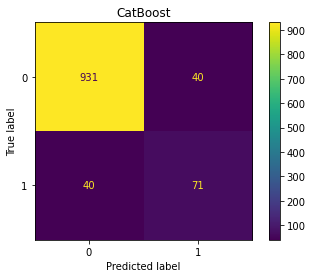

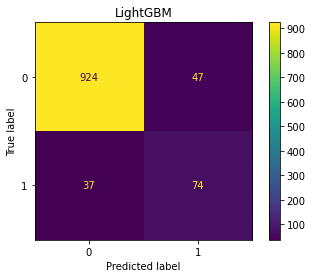

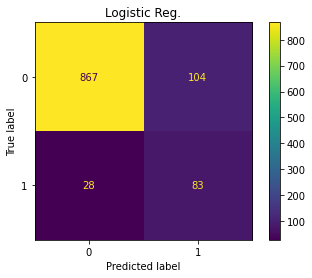

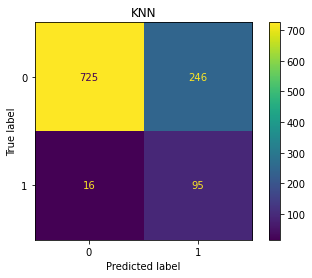

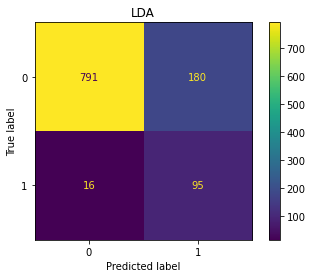

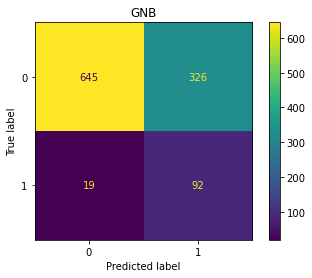

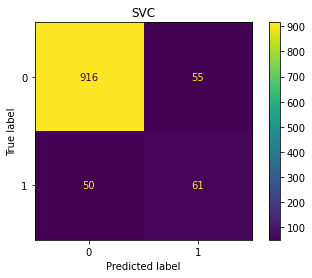

In [75]:
from sklearn.metrics import plot_confusion_matrix, classification_report

# Prep Graphing Procedure
# model_dict_balanced = pickle.load(open('model_dict_balanced.pickle', 'rb'))
model_names = ['CatBoost', 'LightGBM', 'Logistic Reg.', 
               'KNN', 'LDA', 'GNB', 'SVC']
top_dict = {'CatBoost': model_dict_balanced['cb_1'],
           'LightGBM': model_dict_balanced['lgbm_1_opt'],
           'Logistic Reg.': model_dict_balanced['lgr_3'],
           'KNN': model_dict_balanced['knn_3'],
           'LDA': model_dict_balanced['lda_1'],
           'GNB': model_dict_balanced['gnb_1'],
           'SVC': model_dict_balanced['svc_1_opt']}

# Graph Matrices
for model_name in model_names:
    try:
        plot_confusion_matrix(top_dict[model_name], Xtest, ytest)
        plt.title(model_name)
        print(model_name, '\n', classification_report(ytest, top_dict[model_name].predict(Xtest)))
        print(40*'-')
    except:  # For models requiring XtestPCA
        plot_confusion_matrix(top_dict[model_name], XtestPCA, ytest)
        plt.title(model_name)
        print(model_name, '\n', classification_report(ytest, top_dict[model_name].predict(XtestPCA)))

## Surface Level Discussion
[Back to Top](#Machine-Learning-Processing)

In terms of our project goals, **CatBoost** features the optimal precision, with the fewest predicted False Positives and the most True Positives.

-something something savings

## Permutation Importance
[Back to Top](#Machine-Learning-Processing)

From here, we can potentially mine further information by applying Permutation Importance to any of our given models. For the sake of example, we will demonstrate the procedure with CatBoost, considering it made it to the top as the most apparently useful model.

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0.5, 1.0, 'CatBoost Permutation Importance')

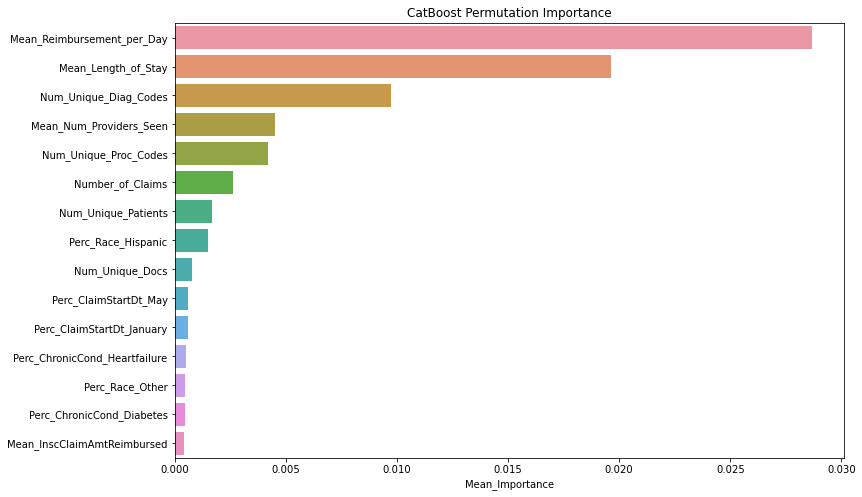

In [55]:
from sklearn.inspection import permutation_importance
fig, axs = plt.subplots(figsize=(12, 8))

perms = permutation_importance(model_dict_balanced['cb_1'], Xtrain, ytrain,
                              n_jobs=-2, random_state=430)
perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                        'Features': Xtrain.columns.to_list()})
perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)

sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'])
plt.ylabel('')
plt.title('CatBoost Permutation Importance')

## Running the Best Models for Full Training Data
[Back to Top](#Machine-Learning-Processing)

Ordinarily this would make for a fine place to finish an ML analysis, however, we are interested in deriving as much precision as possible from our results and can take our findings one step further: we have all of the very best models of each of our selected classifiers and now we can collate their collective, predictive power through stacking techniques.

With this approach, our goal is to gather these models together so that we can generate a clear confidence interval of prediction so that we can better inform our client's decisions at the same time as generating our final predictions of fradulent providers.

In [56]:
### If starting from here, uncomment these #####
# import numpy as np
# import pandas as pd
# import pickle

# # from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA 


def PCAmerge(train, test, n_comp=0.95, r_state=430):
    from sklearn.decomposition import PCA 
    pca = PCA(n_components = n_comp, random_state = r_state)
    train_pca = pd.DataFrame(pca.fit_transform(train), index=train.index)
    test_pca = pd.DataFrame(pca.transform(test), index=test.index)
    PCA_col_list = []
    for num in range(1, train_pca.shape[1]+1):
        PCA_col_list.append(('PCA' + str(num)))
    train_pca.columns = PCA_col_list
    train = pd.concat([train, train_pca], axis=1)
    test_pca.columns = PCA_col_list
    test = pd.concat([test, test_pca], axis=1)
    return train, test



In [57]:
###############################
### Pickle Imports Emporium ###
###############################

model_scores_balanced = pickle.load(open('model_scores_balanced.pickle', 'rb'))
best_models_balanced = pickle.load(open('best_models_balanced.pickle', 'rb'))
model_dict_balanced = pickle.load(open('model_dict_balanced.pickle', 'rb'))
Xtrain_all = pickle.load(open('Xtrain.pickle', 'rb'))
ytrain_all = pickle.load(open('ytrain.pickle', 'rb'))
Xtest_all = pickle.load(open('Xtest.pickle', 'rb'))
ytest_all = pickle.load(open('ytest.pickle', 'rb'))

In [58]:
scaled = StandardScaler()
smiter = SMOTE(n_jobs=-2, random_state=430)
sm_Xtrain_all, sm_ytrain_all = smiter.fit_resample(Xtrain, ytrain)

Xtrain_all_Scaled = pd.DataFrame(scaled.fit_transform(sm_Xtrain_all), columns=sm_Xtrain_all.columns, index=sm_Xtrain_all.index)
Xtest_all_Scaled = pd.DataFrame(scaled.fit_transform(Xtest_all), columns=Xtest_all.columns, index=Xtest_all.index)
Xtrain_all_PCA, Xtest_all_PCA = PCAmerge(Xtrain_all_Scaled, Xtest_all_Scaled, n_comp=0.95)

In [59]:
best_cb = model_dict_balanced['cb_1']
best_cb.fit(sm_Xtrain_all, sm_ytrain_all)

ytest_cb = ytest_all.copy()
ytest_cb['PotentialFraud'] = best_cb.predict(Xtest_all)
ytest_cb['ProbabilityFraud'] = best_cb.predict_proba(Xtest_all)[:,1] 
sum(ytest_cb['PotentialFraud'])

120

In [60]:
best_lgbm = model_dict_balanced['lgbm_1_opt']
best_lgbm.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_lgbm = ytest_all.copy()
ytest_lgbm['PotentialFraud'] = best_lgbm.predict(Xtest_all)
ytest_lgbm['ProbabilityFraud'] = best_lgbm.predict_proba(Xtest_all)[:,1] 
sum(ytest_lgbm['PotentialFraud'])

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


112

In [61]:
best_lgr = model_dict_balanced['lgr_1']
best_lgr.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_lgr = ytest_all.copy()
ytest_lgr['PotentialFraud'] = best_lgr.predict(Xtest_all)
ytest_lgr['ProbabilityFraud'] = best_lgr.predict_proba(Xtest_all)[:,1] 
sum(ytest_lgr['PotentialFraud'])

261

In [62]:
best_knn = model_dict_balanced['knn_2']
best_knn.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_knn = ytest_all.copy()
ytest_knn['PotentialFraud'] = best_knn.predict(Xtest_all)
ytest_knn['ProbabilityFraud'] = best_knn.predict_proba(Xtest_all)[:,1] 
sum(ytest_knn['PotentialFraud'])

457

In [63]:
best_lda = model_dict_balanced['lda_1']
best_lda.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_lda = ytest_all.copy()
ytest_lda['PotentialFraud'] = best_lda.predict(Xtest_all)
ytest_lda['ProbabilityFraud'] = best_lda.predict_proba(Xtest_all)[:,1] 
sum(ytest_lda['PotentialFraud'])

337

In [64]:
best_gnb = model_dict_balanced['gnb_1']
best_gnb.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_gnb = ytest_all.copy()
ytest_gnb['PotentialFraud'] = best_gnb.predict(Xtest_all)
ytest_gnb['ProbabilityFraud'] = best_gnb.predict_proba(Xtest_all)[:,1] 
sum(ytest_gnb['PotentialFraud'])

483

In [65]:
best_svc = Pipeline(steps=[('scaler', StandardScaler()),
                           ('svc', SVC(probability=True))])
best_svc.set_params(**model_dict_balanced['svc_1_opt_params'])
best_svc.fit(sm_Xtrain_all, sm_ytrain_all.values.ravel())

ytest_svc = ytest_all.copy()
ytest_svc['PotentialFraud'] = best_svc.predict(Xtest_all)
ytest_svc['ProbabilityFraud'] = best_svc.predict_proba(Xtest_all)[:,1] 
sum(ytest_svc['PotentialFraud'])

137

In [66]:
ytest_stack_confidence = ytest_all.copy()
ytest_stack_confidence['PotentialFraud'] = (ytest_cb['PotentialFraud'] + ytest_lgbm['PotentialFraud'] + 
                                            ytest_lgr['PotentialFraud'] + ytest_knn['PotentialFraud'] + 
                                            ytest_lda['PotentialFraud'] + ytest_gnb['PotentialFraud'] + 
                                            ytest_svc['PotentialFraud'])  / 7
ytest_stack_confidence

ytest_stacked = np.round(ytest_stack_confidence)
ytest_stacked

,PotentialFraud
Provider,
PRV51002,0.0
PRV51006,0.0
PRV51009,0.0
PRV51010,0.0
PRV51018,0.0
...,...
PRV57713,0.0
PRV57726,0.0
PRV57745,0.0


Generate Model Fraud Probability Data


In [67]:
ytest_stack_confidence_group = ytest_stack_confidence.reset_index().groupby('PotentialFraud').agg('count')
ytest_stack_confidence_group.index = range(8)
ytest_stack_confidence_group['Percentage'] = ytest_stack_confidence_group.Provider / np.sum(ytest_stack_confidence_group.Provider)
ytest_stack_graph = ytest_stack_confidence_group.loc[1:].copy()
ytest_stack_graph['NumModels'] = list(ytest_stack_graph.index)
ytest_stack_graph['NumModels'] = ytest_stack_graph['NumModels'].apply(str) + '/7'
ytest_stack_graph.index = ytest_stack_graph.index - 1
ytest_stack_graph

,Provider,Percentage,NumModels
0,245,0.181079,1/7
1,141,0.104213,2/7
2,55,0.040650,3/7
3,63,0.046563,4/7
4,46,0.033999,5/7
5,30,0.022173,6/7
6,79,0.058389,7/7


In [68]:
ytest_stack_confidence['ProbabilityFraud'] = (ytest_cb['ProbabilityFraud'] + ytest_lgbm['ProbabilityFraud'] + 
                                              ytest_lgr['ProbabilityFraud'] + ytest_knn['ProbabilityFraud'] + 
                                              ytest_lda['ProbabilityFraud'] + ytest_gnb['ProbabilityFraud'] + 
                                              ytest_svc['ProbabilityFraud'])  / 7

# Collate Potentially Fraudulent Providers
PotentialFraud = ytest_stack_confidence[ytest_stack_confidence.PotentialFraud != 0]
PotentialFraud = PotentialFraud.sort_values(['PotentialFraud', 'ProbabilityFraud', 'Provider'], ascending=[False, False, True])
PotentialFraud['NumModels'] = (PotentialFraud['PotentialFraud'] * 7).apply(int).apply(str) + '/7'
PotentialFraud

,PotentialFraud,ProbabilityFraud,NumModels
Provider,,,
PRV53105,1.000000,0.999761,7/7
PRV51407,1.000000,0.999289,7/7
PRV52338,1.000000,0.999183,7/7
PRV53866,1.000000,0.998660,7/7
PRV51982,1.000000,0.998550,7/7
...,...,...,...
PRV52153,0.142857,0.089792,1/7
PRV55488,0.142857,0.089580,1/7
PRV52207,0.142857,0.086924,1/7


Statistics for Probability of Fraud, Grouped by How Many of 7 Models Marked Provider as Fraudulent

In [69]:
def range_(df):
    return max(df) - min(df)
PotentialFraud.groupby('PotentialFraud').agg(['min','mean','median','max', 'std', range_]).sort_values('PotentialFraud', ascending=False)

ProbabilityFraud                                          \
                            min      mean    median       max       std   
PotentialFraud                                                            
1.000000               0.681974  0.905769  0.919635  0.999761  0.087150   
0.857143               0.552181  0.730570  0.737939  0.852843  0.075390   
0.714286               0.512762  0.651858  0.642795  0.804175  0.068926   
0.571429               0.370689  0.515682  0.513355  0.665805  0.061862   
0.428571               0.254622  0.409362  0.402492  0.591193  0.075204   
0.285714               0.193679  0.310423  0.297379  0.482204  0.061537   
0.142857               0.039898  0.173849  0.170083  0.337311  0.047932   

                          
                  range_  
PotentialFraud            
1.000000        0.317787  
0.857143        0.300661  
0.714286        0.291412  
0.571429        0.295116  
0.428571        0.336572  
0.285714        0.288524  
0.142857        0.297413

Export Results

In [70]:
ytest_cb.to_csv('ytest_cb_balanced.csv', header=True)
ytest_lgbm.to_csv('ytest_lgbm_balanced.csv', header=True)
ytest_lgr.to_csv('ytest_lgr_balanced.csv', header=True)
ytest_knn.to_csv('ytest_knn_balanced.csv', header=True)
ytest_lda.to_csv('ytest_lda_balanced.csv', header=True)
ytest_gnb.to_csv('ytest_gnb_balanced.csv', header=True)
ytest_svc.to_csv('ytest_svc_balanced.csv', header=True)
ytest_stack_confidence.to_csv('ytest_stack_confidence_balanced.csv', header=True)
ytest_stacked.to_csv('ytest_stacked_balanced.csv', header=True)
ytest_stack_graph.to_csv('ytest_stack_graph_balanced.csv', header=True)
PotentialFraud.to_csv('PotentialFraud_balanced.csv', header=True)

### Stacking Visualization
[Back to Top](#Machine-Learning-Processing)

#### Grouping Potentially Fraudulent Providers by Model Agreement
 - How many providers are identified as fraudulent by all 7 models?   
 - How many are only identified as fraudulent by 1 model?    
 <b>Answering these questions can help eliminate the biases of a single model choice by displaying the divergences and consensus of a group of models </b>

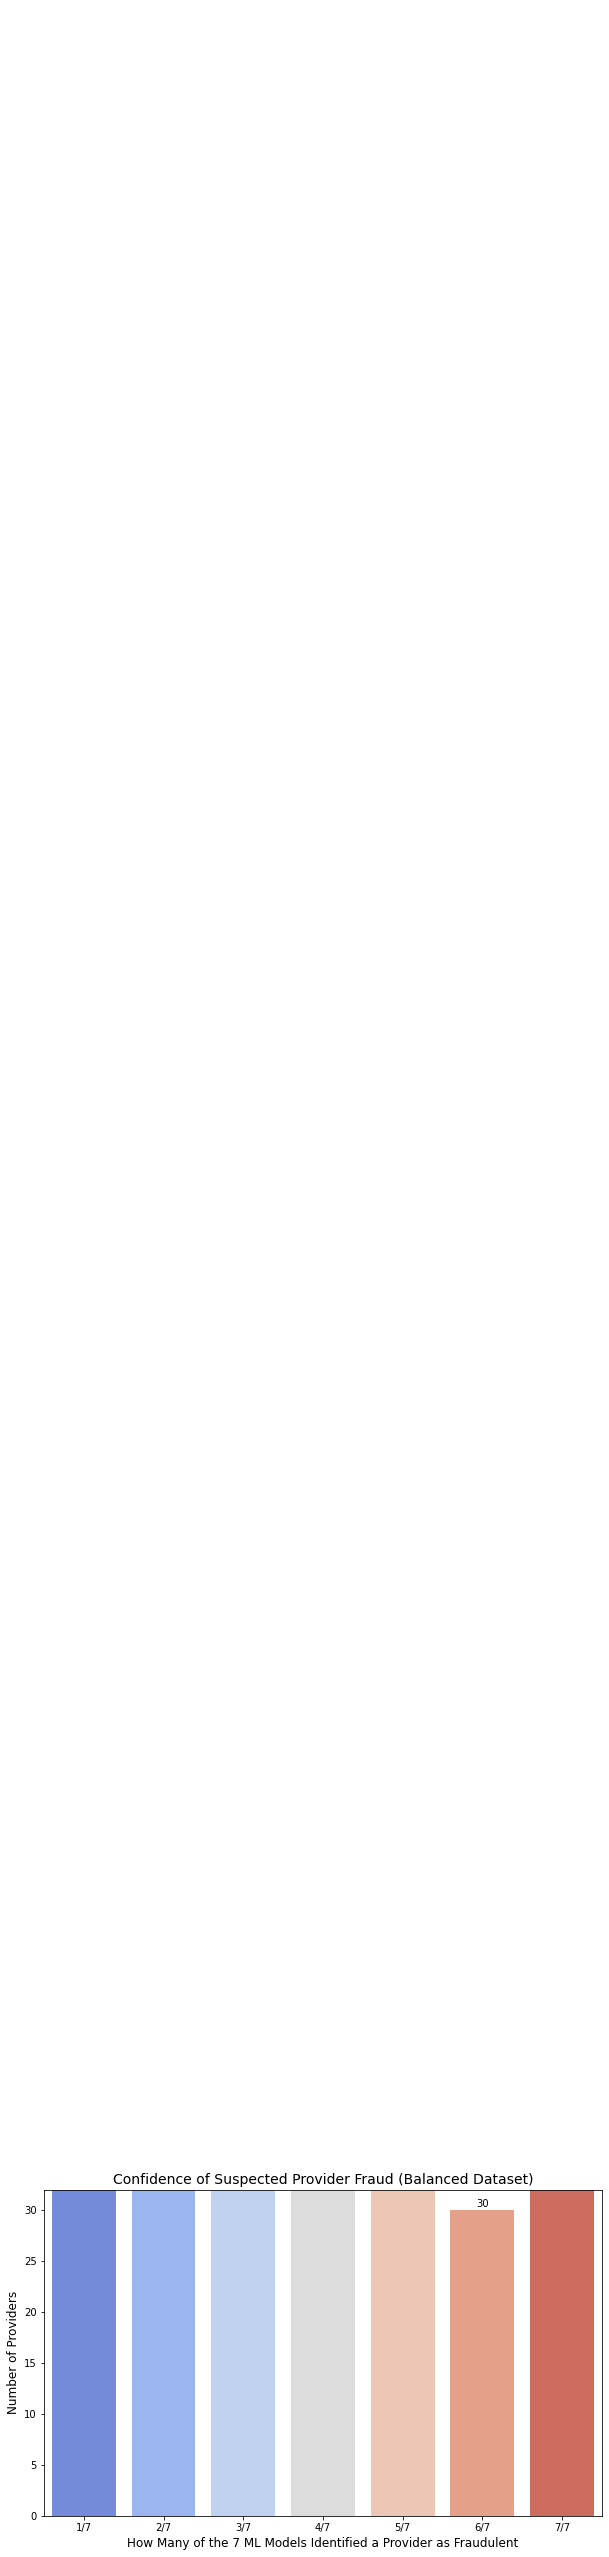

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(10,6))
ax = sns.barplot(x=ytest_stack_graph['NumModels'], y=ytest_stack_graph['Provider'], palette="coolwarm")
plt.title("Confidence of Suspected Provider Fraud (Balanced Dataset)", size=14)
plt.ylabel("Number of Providers", size=12)
plt.xlabel("How Many of the 7 ML Models Identified a Provider as Fraudulent", size=12)
plt.ylim(0,32)

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + .35
    ax.annotate('{:.0f}'.format(ytest_stack_graph['Provider'][i]), (x, y), ha='center')

#### Is there variation in the probability of Fraud among the models identified as Fraudulent?

In [72]:
plt.figure(figsize=(10,8))
PotentialFraudorder = PotentialFraud.sort_values('PotentialFraud', ascending=False)
ax = sns.boxplot(y="NumModels", x="ProbabilityFraud", data=PotentialFraudorder, palette="coolwarm",
                 flierprops=red_circle, showmeans=True, meanprops=yellow_diamond)

plt.title("Machine Learning Confidence in Provider Fraud (Balanced Dataset)", size=16)
ax.set_xlabel('Mean Model Probability of Fraud by Provider', fontsize=13)
ax.set_ylabel('How Many ML Models Identified a Provider as Fraudulent', fontsize=13)
ax.tick_params(labelright = False)
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
legend_elements = [Line2D([0], [0], marker='o', color='red', markeredgecolor='r', markersize=2.5, label='Outlier',
                         linestyle = 'None'),
                   Line2D([1], [1], color='black', lw=2, label='Median', marker='|',
                         linestyle='None',
                          markersize=10, markeredgewidth=1.5,),
                   Line2D([0], [0], marker='D', color='yellow', label='Mean',
                          markerfacecolor='yellow', markeredgecolor='black', markersize=5, linestyle = 'None')]

plt.legend(handles=legend_elements[::-1], loc='lower right')
plt.show      

NameError: name 'red_circle' is not defined

<Figure size 720x576 with 0 Axes>

# Conclusions & Discussion
[Back to Top](#Machine-Learning-Processing)

To recap, much of our exploration here has been to probe the usefulness of unsupervised learning in a pipelined format versus its application as a boosting procedure. Simultaneously, we have employed a diverse number of model types, including some newer devices in the CatBoostClassifier and the LightGBMClassifier.

From much of our results, we have revealed that both uses of PCA have their respective uses, the latter, the PCA Boosting Procedure, seems to have the greatest effect of narrowing overfit results. However, the greatest results of accuracy come to us through the raw, LightGBM results.

With that said, we will now turn our attention to the matter of insight from our findings. To whit, we will break this down into three parts:
   - Feature Importance
   - Prediction Refinement
   - Business Relevance & Benefits

In [ ]:
### For Importing Results
# svc_preds = pd.read_csv('ytest_svc.csv', index_col='Provider')
# lgr_preds = pd.read_csv('ytest_lgr.csv', index_col='Provider')
# lda_preds = pd.read_csv('ytest_lda.csv', index_col='Provider')
# knn_preds = pd.read_csv('ytest_knn.csv', index_col='Provider')
# gnb_preds = pd.read_csv('ytest_gnb.csv', index_col='Provider')
# lgbm_preds = pd.read_csv('ytest_lgbm.csv', index_col='Provider')
# cb_preds = pd.read_csv('ytest_cb.csv', index_col='Provider')
# stacked_preds = pd.read_csv('ytest_stacked.csv', index_col='Provider')